# Let's get the Wikipedia Geodata

In [1]:
from pathlib import Path
import pandas
from geohash_nova import Geohash
from wiki_dump_extractor import WikiSqlExtractor, download_file

## Download and parse the geodata

This dataset contains sites from wikipedia with latitude, longitude, and category.
It is not well curated, there are many sites without names, many sites without category, many pages which are just lists of things, some sites are actually on the moon, etc. We'll do what we can.

In [2]:
wiki_dir = "https://dumps.wikimedia.org/enwiki/20250220/"
filename = "enwiki-20250220-geo_tags.sql.gz"

download_file(f"{wiki_dir}/{filename}", filename, replace=False)

target = Path("geodata.csv.gz")
if not target.exists():
    columns = ["gt_id", "gt_page_id", "gt_name", "gt_type", "gt_lat", "gt_lon"]
    table = WikiSqlExtractor(filename)
    geo_data_df = table.to_pandas_dataframe(columns=columns)
    geo_data_df.to_csv(target, index=False, compression="gzip")
geo_data_df = pandas.read_csv(target)

enwiki-20250220-geo_tags.sql.gz already exists, skipping download.


## Download and parse the pages data

We'll use this data dump to extract page titles and lengths for each site in the geodata set.

In [3]:
filepath = "enwiki-20250220-page.sql.gz"
download_file(f"{wiki_dir}/{filename}", filename, replace=False)

geodata_page_ids = set(geo_data_df["gt_page_id"])

target = Path("pages.csv.gz")
if not target.exists():
    table = WikiSqlExtractor(filepath)
    pages_df = table.to_pandas_dataframe(
        columns=["page_id", "page_title", "page_len"],
        row_filter=lambda row: row["page_id"] in geodata_page_ids,
    )
    pages_df.to_csv(target, index=False, compression="gzip")
pages_df = pandas.read_csv(target)

enwiki-20250220-geo_tags.sql.gz already exists, skipping download.


## Filter geodata, add geohashes

We filter all the geodata with latitude and longitude that not in the usual earthly range, because these are mostly on other planets (that was weird to me, I thought every planet had the same -180/180, -90/90 coordinates but maybe not)

In [4]:
full_df = geo_data_df.merge(pages_df, left_on="gt_page_id", right_on="page_id")
full_df.rename(
    columns={
        "gt_name": "name",
        "gt_lat": "lat",
        "gt_lon": "lon",
        "gt_type": "category",
    },
    inplace=True,
)
off_limit_coordinates = (full_df["lat"].abs() > 90) | (full_df["lon"].abs() > 180)
full_df[off_limit_coordinates]["page_title"]

6188       The_Anome/Offplanet_places_containing_plaintex...
6189       The_Anome/Offplanet_places_containing_plaintex...
6190       The_Anome/Offplanet_places_containing_plaintex...
6192       The_Anome/Offplanet_places_containing_plaintex...
6193       The_Anome/Offplanet_places_containing_plaintex...
                                 ...                        
2590123                           List_of_craters_on_Mercury
2605273                              List_of_mountains_on_Io
2605274                              List_of_mountains_on_Io
2605275                              List_of_mountains_on_Io
2614447                                       Price_(crater)
Name: page_title, Length: 4100, dtype: object

<Axes: xlabel='lon', ylabel='lat'>

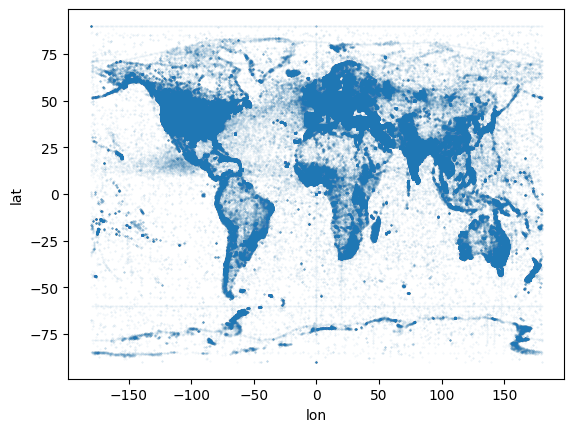

In [5]:
filtered_df = full_df[~off_limit_coordinates].copy()
filtered_df.plot.scatter(x="lon", y="lat", s=0.1, alpha=0.1)

## Compute the geohashes for each site

We will use the geohash to partition the data (easier to download and search) and also display it harmoniously accross different zoom levels.

In [6]:
filtered_df["geohash"] = [
    Geohash.init_with_lat_lng(lat_lng=[lat, lng], length=8).geohash
    for lat, lng in zip(filtered_df["lat"], filtered_df["lon"])
]

## Filter the data

We remove sites from lists, user pages, and pages with craters in the name.

In [ ]:
def to_csv(df, filename):
    saved_columns = ["geohash", "page_title", "name", "page_len", "category"]
    df.sort_values("geohash", ascending=False)[saved_columns].to_csv(
        filename, compression="gzip", index=False, sep="\t"
    )


from_list = filtered_df.page_title.str.contains("List_of")
to_csv(filtered_df[from_list], "from_lists.csv.gz")
from_user = filtered_df.page_title.str.contains("/")
is_crater = filtered_df.page_title.str.lower().str.contains("crater")
filtered_df = filtered_df[~from_list & ~from_user & ~is_crater]
filtered_df = filtered_df.sort_values("page_len", ascending=False)
filtered_df = filtered_df.drop_duplicates("geohash")


## Write the data to disk

We separate the data by 1-st geohash level. We also select a 1000-site and ~17k sites datasets, used when the user is zooming out to the whole planet.

In [32]:
for c, subdf in filtered_df.groupby(filtered_df["geohash"].str[:1]):
    to_csv(subdf, f"geodata/{c}.csv.gz")

df = filtered_df.copy()
df["geohash2"] = df.geohash.str[:2]
df["geohash3"] = df.geohash.str[:3]
df = df[df.page_len < 200_000].sort_values("page_len", ascending=False)
to_csv(df.drop_duplicates("geohash2"), "geodata/geo2_unique.csv.gz")
to_csv(df.drop_duplicates("geohash3"), "geodata/geo3_unique.csv.gz")

9634